# Vector-space models: retrofitting

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [The retrofitting model](#The-retrofitting-model)
1. [Examples](#Examples)
  1. [Only node 0 has outgoing edges](#Only-node-0-has-outgoing-edges)
  1. [All nodes connected to all others](#All-nodes-connected-to-all-others)
  1. [As before, but now 2 has no outgoing edges](#As-before,-but-now-2-has-no-outgoing-edges)
  1. [All nodes connected to all others, but $\alpha = 0$](#All-nodes-connected-to-all-others,-but-$\alpha-=-0$)
1. [WordNet](#WordNet)
  1. [Background on WordNet](#Background-on-WordNet)
  1. [WordNet and VSMs](#WordNet-and-VSMs)
  1. [Reproducing the WordNet synonym graph experiment](#Reproducing-the-WordNet-synonym-graph-experiment)
1. [Other retrofitting models and ideas](#Other-retrofitting-models-and-ideas)

## Overview

* Thus far, all of the information in our word vectors has come solely from co-occurrences patterns in text. This information is often very easy to obtain – though one does need a __lot__ of text – and it is striking how rich the resulting representations can be.

* Nonetheless, it seems clear that there is important information that we will miss this way – relationships that just aren't encoded at all in co-occurrences or that get distorted by such patterns. 

* For example, it is probably straightforward to learn representations that will support the inference that all puppies are dogs (_puppy_ entails _dog_), but it might be difficult to learn that _dog_ entails _mammal_ because of the unusual way that very broad taxonomic terms like _mammal_ are used in text.

* The question then arises: how can we bring structured information – labels – into our representations? If we can do that, then we might get the best of both worlds: the ease of using co-occurrence data and the refinement that comes from using labeled data.

* In this notebook, we look at one powerful method for doing this: the __retrofitting__ model of [Faruqui et al. 2016](http://www.aclweb.org/anthology/N15-1184). In this model, one learns (or just downloads) distributed representations for nodes in a knowledge graph and then updates those representations to bring connected nodes closer to each other.

* This is an incredibly fertile idea; the final section of the notebook reviews some recent extensions, and new ones are likely appearing all the time.

## Set-up

In [2]:
%matplotlib inline
from collections import defaultdict
from nltk.corpus import wordnet as wn
import numpy as np
import os
import pandas as pd
import retrofitting
from retrofitting import Retrofitter
import utils

In [3]:
data_home = 'data'

## The retrofitting model

For an __an existing VSM__ $\widehat{Q}$ of dimension $m \times n$, and a set of __edges__  $E$ (pairs of indices into rows in  $\widehat{Q}$), the retrofitting objective is to obtain a new VSM $Q$ (also dimension $m \times n$)  according to the following objective:

$$\sum_{i=1}^{m} \left[ 
\alpha_{i}\|q_{i} - \widehat{q}_{i}\|_{2}^{2}
+
\sum_{j : (i,j) \in E}\beta_{ij}\|q_{i} - q_{j}\|_{2}^{2}
\right]$$

The left term encodes a pressure to stay like the original vector. The right term encodes a pressure to be more like one's neighbors. In minimizing this objective, we should be able to strike a balance between old and new, VSM and graph.

Definitions:

1. $\|u - v\|_{2}^{2}$ gives the __squared euclidean distance__ from $u$ to $v$.

1. $\alpha$ and $\beta$ are weights we set by hand, controlling the relative strength of the two pressures. In the paper, they use $\alpha=1$ and $\beta = \frac{1}{\{j : (i, j) \in E\}}$.

## Examples

To get a feel for what's happening, it's helpful to visualize the changes that occur in small, easily understood VSMs and graphs. The function `retrofitting.plot_retro_path` helps with this.

In [4]:
Q_hat = pd.DataFrame(
    [[0.0, 0.0],
     [0.0, 0.5],
     [0.5, 0.0]], 
    columns=['x', 'y'])

Q_hat

,x,y
0,0.0,0.0
1,0.0,0.5
2,0.5,0.0


### Only node 0 has outgoing edges

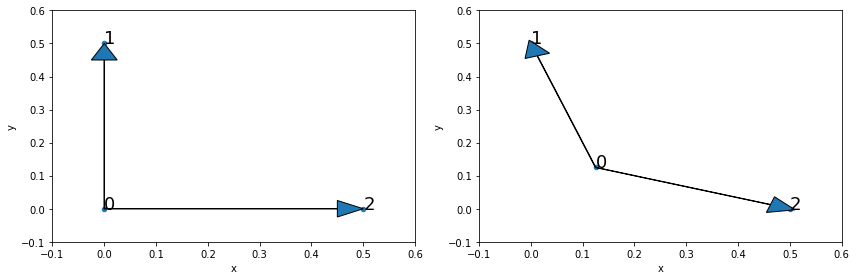

In [5]:
edges_0 = {0: {1, 2}, 1: set(), 2: set()}

_ = retrofitting.plot_retro_path(Q_hat, edges_0)

### All nodes connected to all others

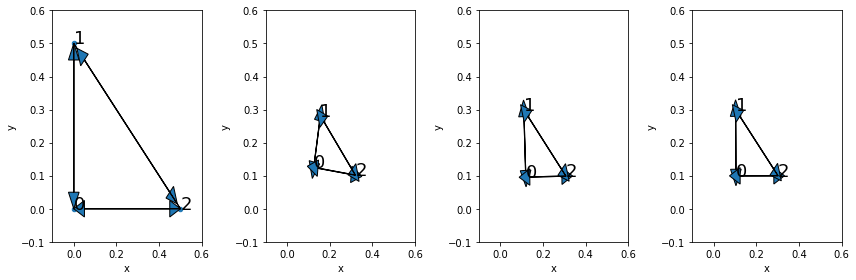

In [6]:
edges_all = {0: {1, 2}, 1: {0, 2}, 2: {0, 1}}

_ = retrofitting.plot_retro_path(Q_hat, edges_all)

### As before, but now 2 has no outgoing edges

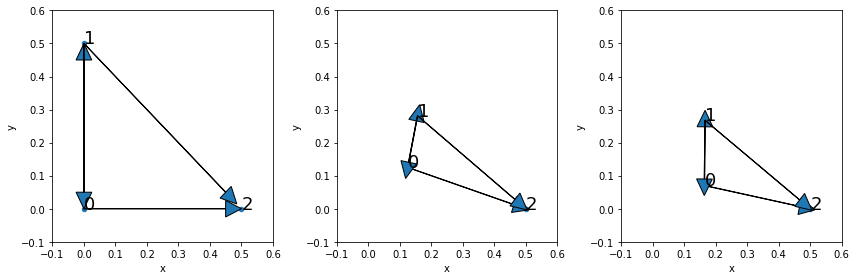

In [7]:
edges_isolated = {0: {1, 2}, 1: {0, 2}, 2: set()}

_ = retrofitting.plot_retro_path(Q_hat, edges_isolated)

### All nodes connected to all others, but $\alpha = 0$

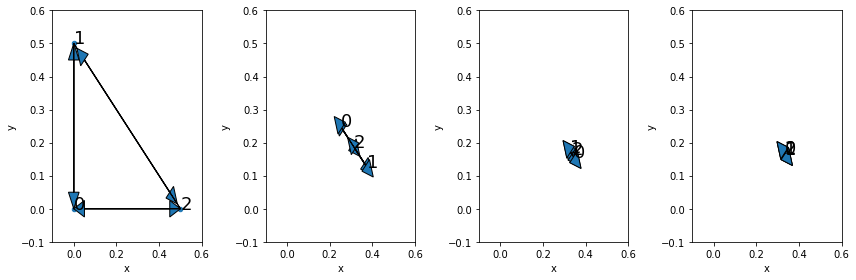

In [8]:
_ = retrofitting.plot_retro_path(
    Q_hat, edges_all, 
    retrofitter=Retrofitter(alpha=lambda x: 0))

## WordNet

Faruqui et al. conduct experiments on three knowledge graphs: [WordNet](https://wordnet.princeton.edu), [FrameNet](https://framenet.icsi.berkeley.edu/fndrupal/), and the [Penn Paraphrase Database (PPDB)](http://paraphrase.org/). [The repository for their paper](https://github.com/mfaruqui/retrofitting) includes the graphs that they derived for their experiments.

Here, we'll reproduce just one of the two WordNet experiments they report, in which the graph is formed based on synonymy.

### Background on WordNet

WordNet is an incredible, hand-built lexical resource capturing a wealth of information about English words and their inter-relationships. ([Here is a collection of WordNets in other languages.](http://globalwordnet.org)) For a detailed overview using NLTK, see [this tutorial](http://compprag.christopherpotts.net/wordnet.html).

The core concepts:

* A __lemma__ is something like our usual notion of __word__. Lemmas are highly sense-disambiguated. For instance, there are six lemmas that are consistent with the string `crane`: the bird, the machine, the poets, ...

* A __synset__ is a collection of lemmas that are synonymous in the WordNet sense (which is WordNet-specific; words with intuitively different meanings might still be grouped together into synsets.).

WordNet is a graph of relations between lemmas and between synsets, capturing things like hypernymy, antonymy, and many others. For the most part, the relations are defined between nouns; the graph is sparser for other areas of the lexicon.

In [9]:
lems = wn.lemmas('crane', pos=None)

for lem in lems:
    ss = lem.synset()
    print("="*70)
    print("Lemma name: {}".format(lem.name()))
    print("Lemma Synset: {}".format(ss))
    print("Synset definition: {}".format(ss.definition()))   

Lemma name: Crane
Lemma Synset: Synset('crane.n.01')
Synset definition: United States writer (1871-1900)
Lemma name: Crane
Lemma Synset: Synset('crane.n.02')
Synset definition: United States poet (1899-1932)
Lemma name: Crane
Lemma Synset: Synset('grus.n.01')
Synset definition: a small constellation in the southern hemisphere near Phoenix
Lemma name: crane
Lemma Synset: Synset('crane.n.04')
Synset definition: lifts and moves heavy objects; lifting tackle is suspended from a pivoted boom that rotates around a vertical axis
Lemma name: crane
Lemma Synset: Synset('crane.n.05')
Synset definition: large long-necked wading bird of marshes and plains in many parts of the world
Lemma name: crane
Lemma Synset: Synset('crane.v.01')
Synset definition: stretch (the neck) so as to see better


### WordNet and VSMs

A central challenge of working with WordNet is that one doesn't usually encounter lemmas or synsets in the wild. One probably gets just strings, or maybe strings with part-of-speech tags. Mapping these objects to lemmas is incredibly difficult.

For our experiments with VSMs, we simply collapse together all the senses that a given string can have. This is expedient, of course. It might also be a good choice linguistically: senses are flexible and thus hard to individuate, and we might hope that our vectors can model multiple senses at the same time. 

(That said, there is excellent work on creating sense-vectors; see [Reisinger and Mooney 2010](http://www.aclweb.org/anthology/N10-1013); [Huang et al 2012](http://www.aclweb.org/anthology/P12-1092).)

The following code uses the NLTK WordNet API to create the edge dictionary we need for using the `Retrofitter` class:

In [10]:
def get_wordnet_edges():
    edges = defaultdict(set)
    for ss in wn.all_synsets():
        lem_names = {lem.name() for lem in ss.lemmas()}
        for lem in lem_names:
            edges[lem] |= lem_names
    return edges

In [11]:
wn_edges = get_wordnet_edges()

### Reproducing the WordNet synonym graph experiment

For our VSM, let's use the 300d file included in this distribution from the GloVe team, as it is close to or identical to the one used in the paper:

http://nlp.stanford.edu/data/glove.6B.zip

If you download this archive, place it in `vsmdata`, and unpack it, then the following will load the file into a dictionary for you:

In [12]:
glove_dict = utils.glove2dict(
    os.path.join(data_home, 'glove.6B', 'glove.6B.300d.txt'))

This is the initial embedding space $\widehat{Q}$:

In [13]:
X_glove = pd.DataFrame(glove_dict).T

In [14]:
X_glove.T.shape

(300, 400000)

Now we just need to replace all of the strings in `edges` with indices into `X_glove`:

In [15]:
def convert_edges_to_indices(edges, Q):
    lookup = dict(zip(Q.index, range(Q.shape[0])))
    index_edges = defaultdict(set)
    for start, finish_nodes in edges.items():
        s = lookup.get(start)
        if s:
            f = {lookup[n] for n in finish_nodes if n in lookup}
            if f:
                index_edges[s] = f
    return index_edges

In [16]:
wn_index_edges = convert_edges_to_indices(wn_edges, X_glove)

And now we can retrofit:

In [17]:
wn_retro = Retrofitter(verbose=True)

In [18]:
X_retro = wn_retro.fit(X_glove, wn_index_edges)

Converged at iteration 10; change was 0.0043 

You can now evaluate `X_retro` using the homework/bake-off notebook [hw_wordsim.ipynb](hw_wordsim.ipynb)!

In [19]:
# Optionally write `X_retro` to disk for use elsewhere:
#
# X_retro.to_csv(
#     os.path.join(data_home, 'glove6B300d-retrofit-wn.csv.gz'), compression='gzip')

## Other retrofitting models and ideas

* The retrofitting idea is very close to __graph embedding__, in which one learns distributed representations of nodes based on their position in the graph. See [Hamilton et al. 2017](https://arxiv.org/pdf/1709.05584.pdf) for an overview of these methods. There are numerous parallels with the material we've reviewed here.

* If you think of the input VSM as a "warm start" for graph embedding algorithms, then you're essentially retrofitting. This connection opens up a number of new opportunities to go beyond the similarity-based semantics that underlies Faruqui et al.'s model. See [Lengerich et al. 2017](https://arxiv.org/pdf/1708.00112.pdf), section 3.2, for more on these connections.

* [Mrkšić  et al. 2016](https://aclanthology.coli.uni-saarland.de/papers/N16-1018/n16-1018) address the limitation of Faruqui et al's model that it assumes connected nodes in the graph are similar. In a graph with complex, varied edge semantics, this is likely to be false. They address the case of antonymy in particular.

* [Lengerich et al. 2017](https://arxiv.org/pdf/1708.00112.pdf) present a __functional retrofitting__ framework in which the edge meanings are explicitly modeled, and they evaluate instantiations of the framework with linear and neural edge penalty functions. (The Faruqui et al. model emerges as a specific instantiation of this framework.)